# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize,labels=range(10)
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

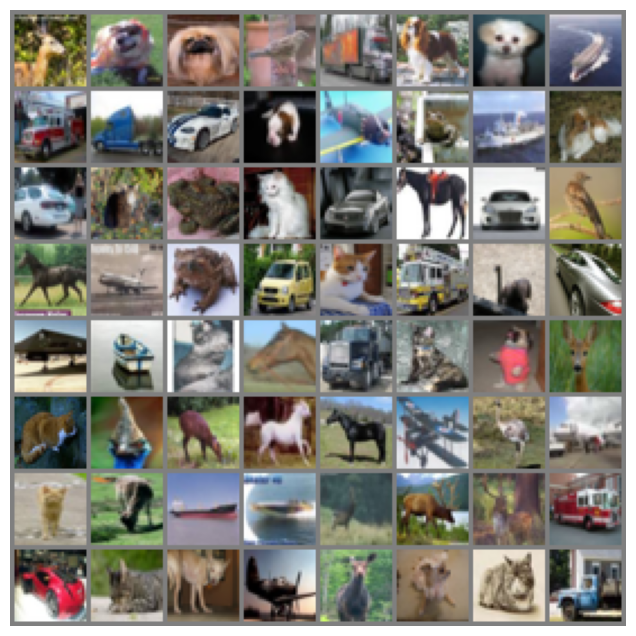

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [5]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)


def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)


def conv7x7(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=stride, padding=3, bias=False)

class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!
        self.conv1 = conv7x7(3,16)
        self.conv2 = conv3x3(16,32)
        self.conv3 = conv3x3(32,64)
        self.conv4 = conv3x3(64,128)
        self.conv5 = conv3x3(128,256)

        self.fc1 = conv1x1(256, 128)
        self.fc2 = conv1x1(128, num_classes)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu = F.relu
        self.sigmoid = torch.sigmoid

    def forward(self, x):
        # Your code here!
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.sigmoid(x)
        return x.squeeze()


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (fc2): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [6]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=1e-5)  # Your code here!


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[0.4069706  0.47345972 0.36028543 0.52720976 0.5731522  0.4680022
  0.5543572  0.46448308 0.4053938  0.637177  ]
 [0.61643404 0.5541584  0.5964747  0.40862918 0.36255956 0.48258394
  0.49072015 0.3649354  0.5923221  0.57081413]]
Output probabilities:
[[0.0919971  0.09832184 0.08780091 0.10375125 0.10862903 0.09778671
  0.10660641 0.09744319 0.09185215 0.11581145]
 [0.11143524 0.10470721 0.10923312 0.09052615 0.08645025 0.09747477
  0.09827107 0.08665589 0.10878046 0.10646579]]


In [8]:
batch_size = 64
num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()
        output = model.forward(inputs)

        loss_targets = torch.nn.functional.one_hot(targets, num_classes=n_classes).to(torch.float)
        #print(output.size(),loss_targets.size())
        batch_loss = loss_fn(output,loss_targets)
        batch_loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)

                    loss_targets = torch.nn.functional.one_hot(targets, num_classes=n_classes).to(torch.float)
                    loss = loss_fn(output, loss_targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.4720625
             test accuracy: 0.3993
Step 1000    training accuracy: 0.586295871559633
             test accuracy: 0.454
Step 1500    training accuracy: 0.61321875
             test accuracy: 0.553
Step 2000    training accuracy: 0.6561424885321101
             test accuracy: 0.5584
Step 2500    training accuracy: 0.698051948051948
             test accuracy: 0.5621
Step 3000    training accuracy: 0.69903125
             test accuracy: 0.5451
Step 3500    training accuracy: 0.7326948924731183
             test accuracy: 0.5486
Step 4000    training accuracy: 0.7479166666666667
             test accuracy: 0.5513
Step 4500    training accuracy: 0.75440625
             test accuracy: 0.5567
Step 5000    training accuracy: 0.7710531655844156
             test accuracy: 0.5496
Step 5500    training accuracy: 0.7860576923076923
             test accuracy: 0.57
Step 6000    training accuracy: 0.78821875
             test accuracy: 0.5759
Step 6500    tr

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

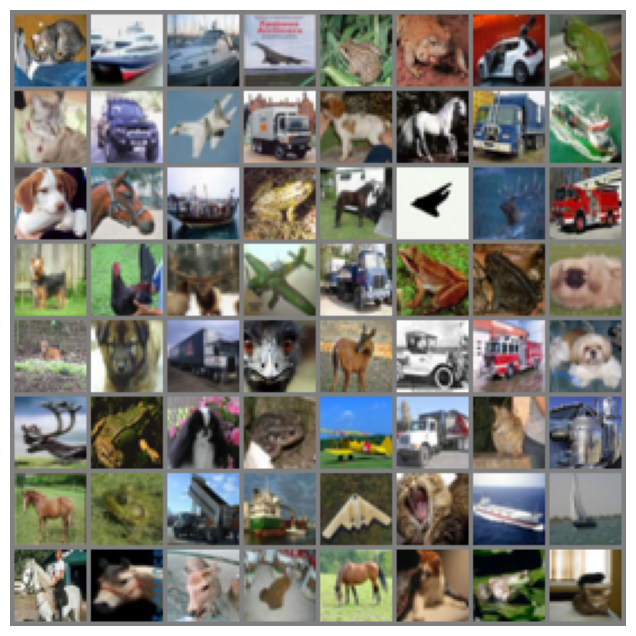

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship       automobile  
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane        ship     
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse      automobile  
  airplane      airplane   
    deer          bird     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           c

In [9]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [10]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [11]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.560


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


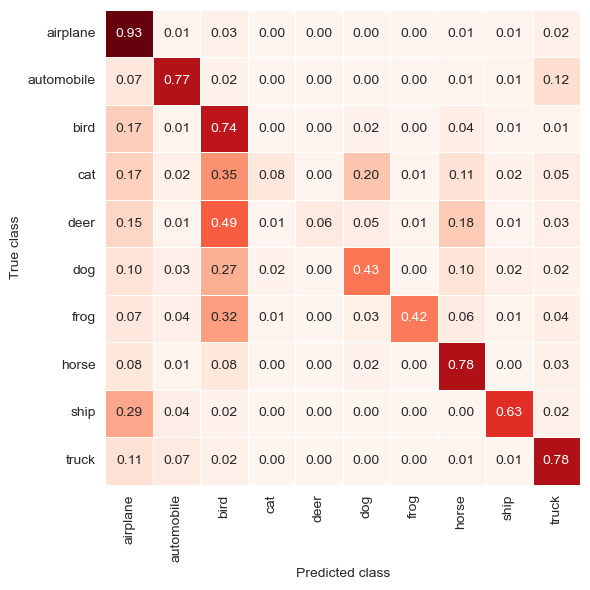

In [12]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

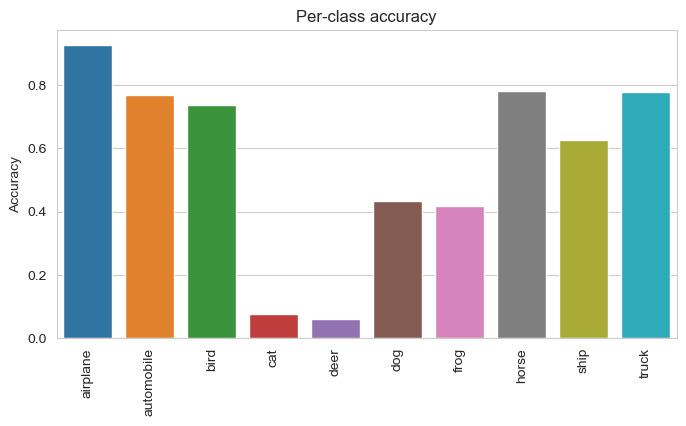

In [13]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

I use pre-trained resnet-50 to extract features in the model.

And try to use learning rate scheduler to change the learning rate in each epoch.

I also changed the batch size to 128 which could let the model fit the data well.

I found that the batch size may influence the training result easier than other hyperparameters, it's hard for the model to fit the data if the batch size is lower than 64.

In [14]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)
        self.fc1 = conv1x1(512, 256)
        self.fc2 = conv1x1(256, self.num_classes)
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu = F.relu
        self.sigmoid = torch.sigmoid

    def forward(self, x):
        x = self.resnet(x).unsqueeze(2).unsqueeze(3)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc1(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.sigmoid(x)
        return x.squeeze()

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: {}".format(device))
model = Model(n_classes)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.65 ** epoch)

num_epochs = 8
validation_every_steps = int(len(train_loader)/5)
step = 0
model.train()
train_accuracies = []
valid_accuracies = []
print("Start training")
for epoch in range(num_epochs):
    lr = optimizer.param_groups[0]['lr']
    print("\nEpoch: {}|lr: {}".format(epoch,lr)) 
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()
        output = model.forward(inputs)

        loss_targets = torch.nn.functional.one_hot(targets, num_classes=n_classes).to(torch.float)
        batch_loss = loss_fn(output,loss_targets)
        batch_loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)

                    loss_targets = torch.nn.functional.one_hot(targets, num_classes=n_classes).to(torch.float)
                    loss = loss_fn(output, loss_targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")
    scheduler.step()

print("Finished training.")

device: cuda:0
Start training

Epoch: 0|lr: 0.0003
Step 78      training accuracy: 0.5531850961538461
             test accuracy: 0.6904
Step 156     training accuracy: 0.7213541666666666
             test accuracy: 0.7402
Step 234     training accuracy: 0.7316706730769231
             test accuracy: 0.7419
Step 312     training accuracy: 0.7509014423076923
             test accuracy: 0.7616
Step 390     training accuracy: 0.7580128205128205
             test accuracy: 0.7533

Epoch: 1|lr: 0.000195
Step 468     training accuracy: 0.8079342532467533
             test accuracy: 0.781
Step 546     training accuracy: 0.8200120192307693
             test accuracy: 0.7907
Step 624     training accuracy: 0.8274238782051282
             test accuracy: 0.8058
Step 702     training accuracy: 0.8315304487179487
             test accuracy: 0.8061
Step 780     training accuracy: 0.8225160256410257
             test accuracy: 0.8102

Epoch: 2|lr: 0.00012675
Step 858     training accuracy: 0.87510279

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [15]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['NVIDIA GeForce RTX 4080 SUPER']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Problem**

Backpropagation in a convolutional network The core equations of backpropagation in a network with fully-connected layers are (BP1)-(BP4) (link). Suppose we have a network containing a convolutional layer, a max-pooling layer, and a fully-connected output layer, as in the network discussed above. How are the equations of backpropagation modified?

**Answer:**

**fully-connected output layer:**

still use (BP1)-(BP4), don't need to change any part.

**max-pooling layer:**

The gradient is only passed to the position which has the maximum value, and the gradient of other positions is 0

**convolutional layer:**

update functions of (BP1)-(BP4):

**(BP1):**
$$\delta^{L} = \nabla_{a} C \odot \sigma'(z^L)$$

**(BP2):**
$$\delta^{l} = (\delta^{l+1} \ast W^{l+1}) \odot \sigma'(z^l)$$

**(BP3):**
$$\frac{\partial C}{\partial b^l_j} = \sum_{i,j} \delta^l_{i,j}$$

**(BP4):**
$$\frac{\partial C}{\partial W^l_{jk}} = \delta^l_{jk} \ast a^{l-1}$$